In [8]:
import random
from ase import Atoms
from ase.calculators.psi4 import Psi4
from ase.io import Trajectory
from pathlib import Path
import matplotlib.pyplot as plt
from mdsim.datasets.lmdb_dataset import LmdbDataset
import numpy as np

random.seed(88)

In [2]:
# copied this over from ase_utils
def data_to_atoms(data):
    numbers = data.atomic_numbers
    positions = data.pos
    cell = data.cell.squeeze()
    atoms = Atoms(numbers=numbers.cpu().detach().numpy(), 
                  positions=positions.cpu().detach().numpy(), 
                  cell=cell.cpu().detach().numpy(),
                  pbc=[True, True, True])
    return atoms

def get_overall_energy(atoms):
    """
    Calculate the overall energy of the system from the elements and their respective energies.
    """
    # list of valid elements and their respective energies
    valid_elem = {35: -70045.28385080204,  # Br
                  6: -1030.5671648271828,  # C
                  17: -12522.649269035726,  # Cl
                  9: -2715.318528602957,  # F
                  1: -13.571964772646918,  # H
                  53: -8102.524593409054,  # I
                  7: -1486.3750255780376,  # N
                  8: -2043.933693071156,  # O
                  15: -9287.407133426237,  # P
                  16: -10834.4844708122}  # S
    
    total = 0
    for an in atoms.get_atomic_numbers():
        if an in valid_elem:
            total += valid_elem[an]
    return total

In [3]:
def get_atoms(from_dataset, init_idx=None):
    if from_dataset:
        # get the molecule from the dataset
        # test_dataset = LmdbDataset({'src': '/data/shared/md17/aspirin/10k/test'})
        test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
        if init_idx is None:
            init_idx = random.randint(0, len(test_dataset))
        init_data = test_dataset[init_idx]
        atoms = data_to_atoms(init_data)
        print(f"reference energy {init_data.reference_energy}")
    else:
        # get atoms from the trajectory file from the simulation
        md_dir = Path('../MODELPATH/maceoff_split_gemnet_dT_results/md_25ps_123_init_8888')
        traj = Trajectory(md_dir / 'atoms.traj')
        atoms = traj[1] # gets unstable very quick
    print(f'overall energy from atoms {get_overall_energy(atoms)}')
    return atoms

In [5]:
# find benzene
test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
seen = set()
with open('str_atoms_leq_6.txt', 'w') as f:
    for i in range(len(test_dataset)):
        init_data = test_dataset[i]
        atoms = data_to_atoms(init_data)
        if len(str(atoms.symbols)) <= 6 and str(atoms.symbols) not in seen:
            seen.add(str(atoms.symbols))
            f.write(f'{i} {str(atoms.symbols)}\n')

In [ ]:
atoms = get_atoms(from_dataset=True, init_idx=8888)

In [9]:
traj = Trajectory('testing_atoms_1211.traj')
print(len(traj))
atoms = traj[-1]

501


In [10]:
# md17 aspirin settings, with coupled cluster
# calc = Psi4(atoms = atoms,
#         method = 'ccsd',
#         memory = '2GB',
#         basis = 'cc-pvdz')

# the spice settings
calc = Psi4(atoms = atoms,
        method = 'wB97M-D3BJ',
        memory = '2GB',
        basis = 'def2-TZVPPD')

In [11]:
atoms.calc = calc
pe = atoms.get_potential_energy()
# forces = atoms.get_forces()
print(pe)
# print(forces)

-110568.68119073089


In [14]:
# this is for init idx 1211
traj_0_energy = -110568.67097818793
traj_last_energy = -110568.68119073089
(traj_last_energy - traj_0_energy) * 1000

-10.212542954832315

In [2]:
# this is for init idx 2886
traj_0_energy = -22155.20406908426
traj_last_energy = -22154.976902755425
-22154.976902755425
(traj_last_energy - traj_0_energy) * 1000

227.1663288338459

In [3]:
# this is for init idx 7738
traj_0_energy = -81372.20816708777
traj_last_energy = -81372.11823730514
(traj_last_energy - traj_0_energy) * 1000
# ran again and got the last energy = -81372.13913798494 -> difference of -69.0291028295178 meV
# simulations nondeterministic

89.92978262540419

In [4]:
with open("maceoff_split_ref_energies.txt", "r") as file:
    # Read each line and strip the newline character
    vals = [float(line.strip()) for line in file]

In [23]:
vals_np = np.array(vals)
# vals_np = vals_np[vals_np > -250]
print(len(vals_np))
print(np.mean(vals_np))
print(np.std(vals_np))
print(np.min(vals_np))
print(np.max(vals_np))
print(np.sum(vals_np < -250) / len(vals_np))

951004
-140.80357353831337
69.16675281685548
-514.9567904545256
-1.895640401984565
0.008114582062746319


In [ ]:
mean = np.mean(vals_np)
std = np.std(vals_np)
standardized_data = (vals_np - mean) / std

In [ ]:
log_transformed_data = np.log(np.abs(vals_np) + 1)

In [18]:
from scipy.stats import boxcox
transformed_data, _ = boxcox(vals_np - np.min(vals_np) + 1)  # Add 1 to shift data into positive range
print(np.mean(transformed_data))
print(np.min(transformed_data))
print(np.max(transformed_data))

40.18202333874582
0.0
47.92009918928075


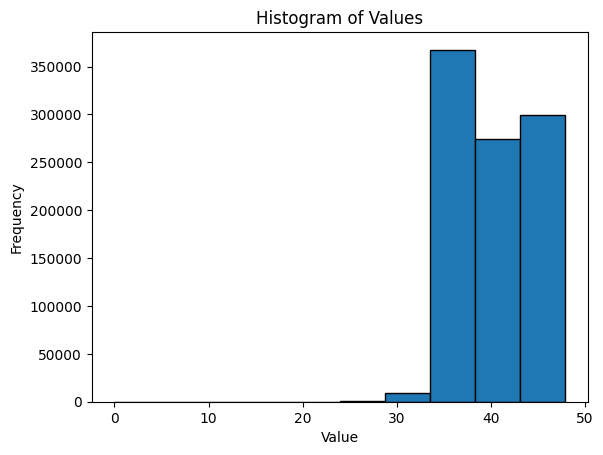

In [17]:
plt.hist(transformed_data, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the plot
plt.show()